# CanEat
**fresh and rotten classification**

This project will explores the development of an automated fresh and rotten classification system using Machine Learning.

## Setup and Download The Dataset

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                              Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38          24881        529  1.0              
dem0nking/video-game-ratings-dataset                                Video Game Ratings Dataset                            2KB  2024-05-23 18:06:30            530         25  1.0              
kanchana1990/perfume-e-commerce-dataset-2024                        Perfume E-Commerce Dataset 2024                     106KB  2024-05-24 18:53:32            501         25  1.0              
jainaru/marvel-movies-box-office-data   

In [6]:
!kaggle datasets download -d 'swoyam2609/fresh-and-stale-classification'

Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0
100% 2.83G/2.84G [00:36<00:00, 141MB/s]
100% 2.84G/2.84G [00:37<00:00, 82.3MB/s]


In [7]:
import zipfile

In [8]:
dataset_zip = zipfile.ZipFile('fresh-and-stale-classification.zip', 'r')

dataset_zip.extractall()

dataset_zip.close()

## Import Packages

In [9]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Prepare The Dataset

In [10]:
# Define the directories
train_dir = '/content/dataset/Train'
validation_dir = '/content/dataset/Test'

# Define function to load data
def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6:])
            filenames.append(os.path.join(PATH, file, img))
    df = pd.DataFrame({
        'filename': filenames,
        'fruit': fruit,
        'fresh': fresh
    })
    return df

# Load training and validation data
df_train = load_data(train_dir).sample(frac=1)
df_test = load_data(validation_dir).sample(frac=1)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23619 entries, 19508 to 11834
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  23619 non-null  object
 1   fruit     23619 non-null  object
 2   fresh     23619 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 738.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6738 entries, 274 to 6571
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6738 non-null   object
 1   fruit     6738 non-null   object
 2   fresh     6738 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 210.6+ KB


In [12]:
import shutil

# Define the mapping of incorrect classes name
rename_mapping = {
    'freshpatato': 'freshpotato',
    'freshtamto': 'freshtomato',
    'rottenpatato': 'rottenpotato',
    'rottentamto': 'rottentomato'
}

# Rename the directories
for incorrect_name, correct_name in rename_mapping.items():
    incorrect_path = os.path.join(validation_dir, incorrect_name)
    correct_path = os.path.join(validation_dir, correct_name)
    if os.path.exists(incorrect_path):
        shutil.move(incorrect_path, correct_path)

# Verify the corrected directories
print("Corrected Validation set classes:", os.listdir(validation_dir))

Corrected Validation set classes: ['rottenpotato', 'rottenokra', 'rottencucumber', 'freshokra', 'rottentomato', 'freshtomato', 'rottenbanana', 'freshpotato', 'freshbanana', 'freshcucumber', 'freshapples', 'rottenoranges', 'freshoranges', 'rottenapples']


In [13]:
# Filter out unnecessary classes
unnecessary_classes = ['bittergroud', 'capsicum', 'cucumber']
for cls in unnecessary_classes:
    shutil.rmtree(os.path.join(train_dir, 'fresh' + cls), ignore_errors=True)
    shutil.rmtree(os.path.join(train_dir, 'rotten' + cls), ignore_errors=True)
    shutil.rmtree(os.path.join(validation_dir, 'fresh' + cls), ignore_errors=True)
    shutil.rmtree(os.path.join(validation_dir, 'rotten' + cls), ignore_errors=True)

# Verify the classes
print("Training set classes:", os.listdir(train_dir))
print("Validation set classes:", os.listdir(validation_dir))

Training set classes: ['rottenpotato', 'rottenokra', 'freshokra', 'rottentomato', 'freshtomato', 'rottenbanana', 'freshpotato', 'freshbanana', 'freshapples', 'rottenoranges', 'freshoranges', 'rottenapples']
Validation set classes: ['rottenpotato', 'rottenokra', 'freshokra', 'rottentomato', 'freshtomato', 'rottenbanana', 'freshpotato', 'freshbanana', 'freshapples', 'rottenoranges', 'freshoranges', 'rottenapples']


## Data Preprocessing

In [21]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(
                                         directory=train_dir,
                                         batch_size=50,
                                         class_mode='categorical',
                                         target_size=(150, 150))

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=validation_dir,
    batch_size=20,
    class_mode='categorical',
    target_size=(150, 150))

# Verify the classes in the generators
print("Training set classes:", train_generator.class_indices)
print("Validation set classes:", validation_generator.class_indices)

# Generate a batch of data
x_batch, y_batch = train_generator.next()

# Print the shape and first few labels
print("Labels shape:", y_batch.shape)
print("First few labels:", y_batch[:5])

Found 20127 images belonging to 12 classes.
Found 6204 images belonging to 12 classes.
Training set classes: {'freshapples': 0, 'freshbanana': 1, 'freshokra': 2, 'freshoranges': 3, 'freshpotato': 4, 'freshtomato': 5, 'rottenapples': 6, 'rottenbanana': 7, 'rottenokra': 8, 'rottenoranges': 9, 'rottenpotato': 10, 'rottentomato': 11}
Validation set classes: {'freshapples': 0, 'freshbanana': 1, 'freshokra': 2, 'freshoranges': 3, 'freshpotato': 4, 'freshtomato': 5, 'rottenapples': 6, 'rottenbanana': 7, 'rottenokra': 8, 'rottenoranges': 9, 'rottenpotato': 10, 'rottentomato': 11}
Labels shape: (50, 12)
First few labels: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Build and Train The Model

In [22]:
def create_cnn_model(num_classes):
    model = tf.keras.models.Sequential([
        # Convolutional Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),

        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Convolutional Layer 4
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten the output
        Flatten(),

        # Dense Layer 1
        Dense(512, activation='relu'),

        # Dropout for regularization
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')  # 12 classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [24]:
num_classes = len(train_generator.class_indices)
model = create_cnn_model(num_classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.999):
#       print("\nReached 99.9% accuracy so cancelling training!")
#       self.model.stop_training = True

# callbacks = myCallback()

In [25]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    verbose=1)
                    # callbacks=[callbacks])

Epoch 1/50
403/403 [==============================] - 205s 489ms/step - loss: 1.1546 - accuracy: 0.5978 - val_loss: 0.5780 - val_accuracy: 0.7945
Epoch 2/50
403/403 [==============================] - 191s 474ms/step - loss: 0.6678 - accuracy: 0.7567 - val_loss: 0.4528 - val_accuracy: 0.8312
Epoch 3/50
403/403 [==============================] - 191s 474ms/step - loss: 0.5129 - accuracy: 0.8151 - val_loss: 0.3210 - val_accuracy: 0.8804
Epoch 4/50
403/403 [==============================] - 192s 477ms/step - loss: 0.4242 - accuracy: 0.8459 - val_loss: 0.2482 - val_accuracy: 0.9064
Epoch 5/50
403/403 [==============================] - 191s 474ms/step - loss: 0.3733 - accuracy: 0.8616 - val_loss: 0.3283 - val_accuracy: 0.8746
Epoch 6/50
403/403 [==============================] - 191s 474ms/step - loss: 0.3332 - accuracy: 0.8780 - val_loss: 0.3021 - val_accuracy: 0.8810
Epoch 7/50
403/403 [==============================] - 192s 476ms/step - loss: 0.3046 - accuracy: 0.8884 - val_loss: 0.1937 -

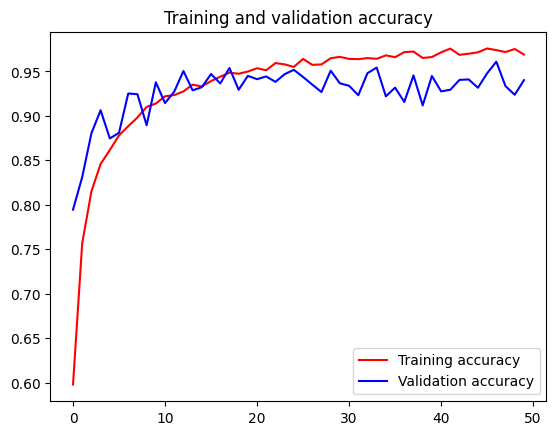

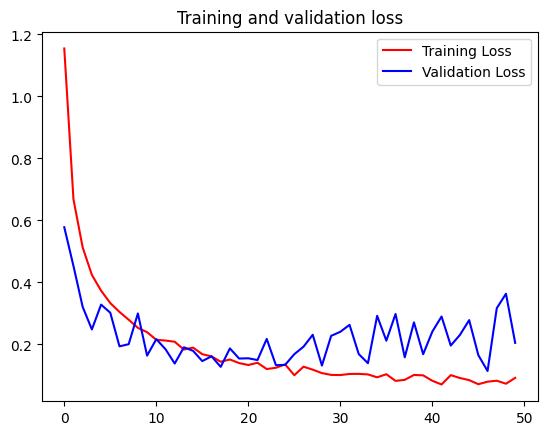

In [26]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate The Model

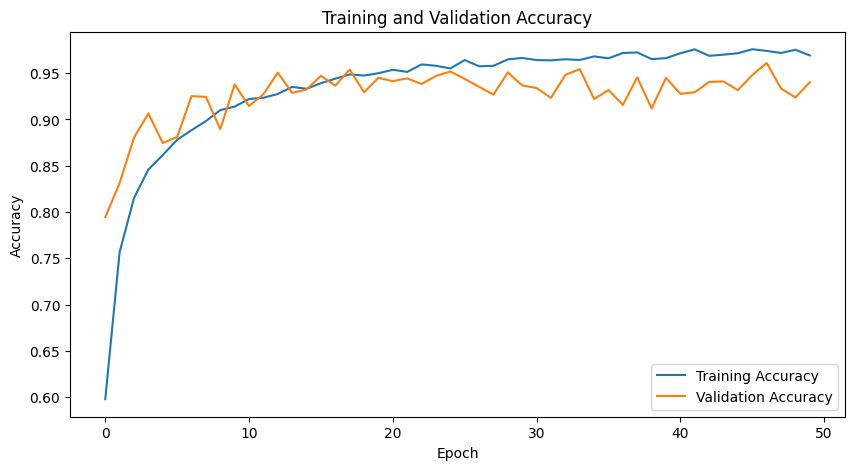

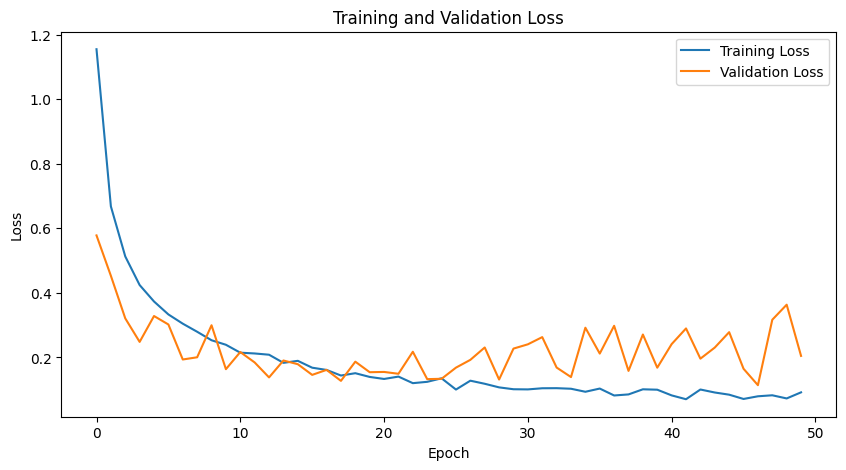

311/311 - 22s - loss: 0.2048 - accuracy: 0.9402 - 22s/epoch - 72ms/step
Validation Loss: 0.2048
Validation Accuracy: 94.02%


In [36]:
# Training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation results
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=2)
val_accuracy_percent = val_accuracy * 100
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy_percent:.2f}%")

## Save and Convert The Model

In [37]:
# Save the model
model.save('my_model.h5')
print("Model saved to 'my_model.h5'")

Model saved to 'my_model.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Load the saved Keras model
model = tf.keras.models.load_model('my_model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite and saved as 'model.tflite'")

Model converted to TFLite and saved as 'model.tflite'


## Model Prediction

In [34]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

def predict_uploaded_image(model):
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load the image
        img = image.load_img(fn, target_size=(150, 150))
        # Convert the image to an array and Scale the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        # Make predictions
        classes = model.predict(x, batch_size=10)
        # Get the class indices
        class_indices = train_generator.class_indices
        # Get the predicted class label
        predicted_class = list(class_indices.keys())[np.argmax(classes)]
        print("File:", fn)
        print("Predicted Class:", predicted_class)
        print("Probabilities:", classes)

predict_uploaded_image(model)

Saving tomat.jpg to tomat.jpg
1/1 [==============================] - 0s 18ms/step
File: tomat.jpg
Predicted Class: freshtomato
Probabilities: [[2.6796440e-10 3.9133621e-15 1.1947192e-16 3.4228563e-13 2.2952847e-10
  9.9999797e-01 7.4628741e-12 3.6364569e-15 2.3851349e-10 1.7006249e-12
  3.3025757e-10 1.9918232e-06]]


In [35]:
# # Predict uploaded image
# import numpy as np
# from google.colab import files
# from tensorflow.keras.preprocessing import image

# def predict_uploaded_image(model, train_generator):
#     uploaded = files.upload()

#     for fn in uploaded.keys():
#         img = image.load_img(fn, target_size=(150, 150))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         x = x / 255.0
#         classes = model.predict(x)
#         class_indices = train_generator.class_indices
#         class_labels = list(class_indices.keys())
#         predicted_class = class_labels[np.argmax(classes)]
#         print("File:", fn)
#         print("Predicted Class:", predicted_class)
#         print("Probabilities:", classes)

# predict_uploaded_image(model, train_generator)

Saving rottenapple_435795946.jpg to rottenapple_435795946.jpg
1/1 [==============================] - 0s 18ms/step
File: rottenapple_435795946.jpg
Predicted Class: rottenapples
Probabilities: [[2.3350170e-16 8.3435768e-14 7.6976574e-25 1.4563700e-15 7.2290158e-07
  3.5750707e-13 9.4148755e-01 1.8073807e-06 3.6510994e-10 5.8427382e-02
  8.2594030e-05 2.0679838e-09]]
